In [1]:
import litebird_sim as lbs
import numpy as np
import healpy as hp
from dataclasses import asdict
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nside = 64
mission_time_is_sec = 24*3600
instrument = "MFT"
channel = "M1-140"
sampling = 1 # this replaces channelinfo.sampling_rate_hz

In [3]:
imo = lbs.Imo()
sim = lbs.Simulation(base_path="./tutorial",
                     start_time=0,
                     duration_s=mission_time_is_sec,
                    )

In [4]:
mft_file = sim.imo.query("/releases/v1.0/satellite/"+instrument+"/instrument_info")
sim.generate_spin2ecl_quaternions(imo_url="/releases/v1.0/satellite/scanning_parameters/")
instrumentinfo = lbs.InstrumentInfo(name=instrument, 
    boresight_rotangle_rad=np.deg2rad(mft_file.metadata["boresight_rotangle_deg"]),
    spin_boresight_angle_rad=np.deg2rad(mft_file.metadata["spin_boresight_angle_deg"]),
    spin_rotangle_rad=np.deg2rad(mft_file.metadata["spin_rotangle_deg"]),
    )
channelinfo = lbs.FreqChannelInfo.from_imo(
    url="/releases/v1.0/satellite/"+instrument+"/"+channel+"/channel_info",
    imo=imo,
    )
hwp_radpsec = mft_file.metadata["hwp_rpm"]*2.0*np.pi/60.0

In [5]:
dets=[]
detquats=[]
#for detname in channelinfo.detector_names[0:20]:
for detname in ('M03_030_QA_140T','M03_030_QA_140B'): #we choose the couple of detector at the MFT boresight
    det=lbs.DetectorInfo.from_imo(
        url="/releases/v1.0/satellite/"+instrument+"/"+channel+"/"+detname+"/detector_info",
        imo=imo,
    )
    det.sampling_rate_hz = sampling
    dets.append(det)
    detquats.append(det.quat)

## Create file with HWP non-ideal parameters for MFT
#### The files 'M/HFT_Mesh_HWP_v2.txt' are given from the simulated HWP profiles at https://wiki.kek.jp/download/attachments/123338913/2019_06_22_MFT_HFT_HWP_GP_to_LB_team.xlsx?version=1&modificationDate=1585750021431&api=v2. We read the MFT one to convert the parameters in the way defined in Giardiello et al.

In [6]:
mft = np.loadtxt('MFT_Mesh_HWP_v2.txt')     

nu = mft[:,0]
h1 = np.sqrt(mft[:,1]) - 1.
h2 = np.sqrt(mft[:,3]) - 1.
beta  = mft[:,5] - 180.
z1 = 0.01*np.ones_like(nu) 
z2 = 0.01*np.ones_like(nu)

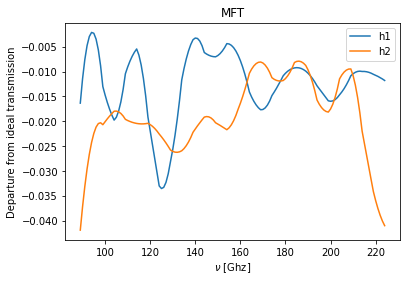

In [9]:
plt.plot(nu,h1,label='h1')
plt.plot(nu,h2,label='h2')
plt.xlabel(r'$\nu$ [Ghz]')
plt.ylabel('Departure from ideal transmission')
plt.title('MFT')
plt.legend()

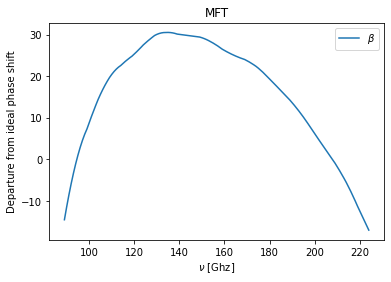

In [10]:
plt.plot(nu,beta,label=r'$\beta$')
plt.xlabel(r'$\nu$ [Ghz]')
plt.ylabel('Departure from ideal phase shift')
plt.title('MFT')
plt.legend()

for the purpose of this exercise, let's focus on the frequencies of the 100 GHz band (89,111)

In [7]:
i_i = np.where(nu == 89)[0][0]
i_f = np.where(nu == 111)[0][0]
Nu=nu[i_i:i_f]
H1=h1[i_i:i_f]
H2=h2[i_i:i_f]
Beta=beta[i_i:i_f]
Z1=z1[i_i:i_f]
Z2=z2[i_i:i_f]

In [8]:
np.savetxt('MFT_100_h_beta_z.txt', np.column_stack((Nu,H1,H2,Beta,Z1,Z2))) 

In [9]:
par = { 'hwp_sys':
       {'band_filename': 'MFT_100_h_beta_z.txt',
        'band_filename_solver': 'MFT_100_h_beta_z.txt',  #same as tod parameters
       }
      }

## Fill tod with a band top-hat + wings

In [10]:
obs, = sim.create_observations(detectors=dets)

pointings = lbs.scanning.get_pointings(obs,
                                       spin2ecliptic_quats=sim.spin2ecliptic_quats,
                                       detector_quats=detquats,
                                       bore2spin_quat=instrumentinfo.bore2spin_quat,
                                      )

if you are using band integration (`integrate_in_band = True` in `hwp_sys.set_parameters`) you don't need to create a map beforehand, the `set_parameters` function of HwpSys will generate one cmb+fg map for each frequency. The following cell is commented because it is not needed when using band integration

In [12]:
#Mbsparams = lbs.MbsParameters(make_cmb =True,
#                              make_fg = False,
#                              gaussian_smooth = True,
#                              bandpass_int = False,
#                              nside = nside,
#                             )

#mbs = lbs.Mbs(simulation=sim,
#              parameters=Mbsparams,
#              channel_list=channelinfo,
#             )
#maps = mbs.run_all()[0][channel]

[2021-12-30 12:21:37,845 INFO MPI#0000] generating and saving cmb simulations
[2021-12-30 12:21:37,863 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2021-12-30 12:21:38,077 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 12:21:38,077 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from tutorial/cmb/0000/cmb_0000_date_211230.fits
  warnings.warn(f"Access data from {full_path}")
[2021-12-30 12:21:38,960 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2021-12-30 12:21:38,963 INFO MPI#0000] NSIDE = 512
[2021-12-30 12:21:38,963 INFO MPI#0000] ORDERING = RING in fits file
[2021-12-30 12:21:38,964 INFO MPI#0000] INDXSCHM = IMPLICIT


***************** D
***************** D
***************** D


[2021-12-30 12:21:39,725 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2021-12-30 12:21:44,631 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2021-12-30 12:21:44,632 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2021-12-30 12:21:44,676 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 12:21:44,676 INFO MPI#0000] -> fwhm is 0.000000 arcmin


In [10]:
sim.parameter_file = par   #setting the parameter file
hwp_sys_band = lbs.HwpSysAndBandpass(sim)

Text(0, 0.5, 'transmission')

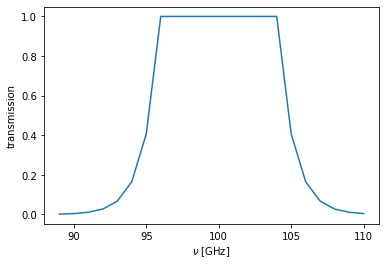

In [12]:
bandpass_parameters={'low edge': 96,'high edge': 104,'alpha': 0.9}
transmission=lbs.out_of_band_analysis.out_of_band_analysis.decaying_bandpass(Nu,
                                        bandpass_parameters['low edge'],
                                        bandpass_parameters['high edge'],
                                           bandpass_parameters['alpha'])
plt.plot(Nu,transmission)
plt.xlabel(r'$\nu$ [GHz]')
plt.ylabel('transmission')

the next command will take a while with band integration, since it has to generate one map per frequency

In [23]:
hwp_sys_band.set_parameters(#maps=maps,    # ---> to use without band integration
                       integrate_in_band=True,
                       correct_in_solver=True,
                       built_map_on_the_fly=False,
                       nside=nside,
                       bandpass_parameters={'low edge': 96,
                                            'high edge': 104,'alpha': 0.9}, #a fake band smaller than the 
    #100GHz one, in order to generate less maps
                       include_beam_throughput=True
                      )

[2022-01-25 12:03:09,256 INFO MPI#0000] using the passed instrument to generate maps
[2022-01-25 12:03:09,259 INFO MPI#0000] generating and saving cmb simulations
[2022-01-25 12:03:09,270 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2022-01-25 12:03:09,274 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-01-25 12:03:09,274 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from tutorial/cmb/0000/cmb_0000_date_220125.fits
  warnings.warn(f"Access data from {full_path}")
[2022-01-25 12:03:09,289 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2022-01-25 12:03:09,295 INFO MPI#0000] NSIDE = 64
[2022-01-25 12:03:09,295 INFO MPI#0000] ORDERING = RING in fits file
[2022-01-25 12:03:09,296 INFO MPI#0000] INDXSC

***************** D
***************** D
***************** D


[2022-01-25 12:03:09,489 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-01-25 12:03:09,489 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-01-25 12:03:09,490 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-01-25 12:03:09,490 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-01-25 12:03:09,548 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-01-25 12:03:09,549 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-01-25 12:03:09,549 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-01-25 12:03:09,550 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-01-25 12:03:09,597 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-01-25 12:03:09,598 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-01-25 12:03:09,598 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-01-25 12:03:09,599 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-01-25 12:03:09,647 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-01-25 12:03:09,648 INFO M

[2022-01-25 12:03:11,650 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-01-25 12:03:11,651 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-01-25 12:03:11,653 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-01-25 12:03:11,719 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-01-25 12:03:11,721 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-01-25 12:03:11,723 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-01-25 12:03:11,724 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-01-25 12:03:11,779 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-01-25 12:03:11,780 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-01-25 12:03:11,782 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-01-25 12:03:11,783 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-01-25 12:03:11,833 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-01-25 12:03:11,834 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-01-25 12:03:11,836 INFO MPI#0000] Sigma

[2022-01-25 12:03:15,638 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-01-25 12:03:15,793 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-01-25 12:03:15,795 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-01-25 12:03:15,796 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-01-25 12:03:15,798 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-01-25 12:03:15,916 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-01-25 12:03:15,918 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-01-25 12:03:15,920 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-01-25 12:03:15,922 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-01-25 12:03:16,041 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-01-25 12:03:16,043 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-01-25 12:03:16,044 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-01-25 12:03:16,046 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-01-25 12:03:16,126 INFO MPI#0000] Sigma

[2022-01-25 12:03:18,932 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-01-25 12:03:18,933 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-01-25 12:03:18,934 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-01-25 12:03:19,051 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-01-25 12:03:19,053 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-01-25 12:03:19,055 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-01-25 12:03:19,056 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-01-25 12:03:19,154 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-01-25 12:03:19,156 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-01-25 12:03:19,158 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-01-25 12:03:19,161 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-01-25 12:03:19,265 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-01-25 12:03:19,267 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-01-25 12:03:19,268 INFO MPI#0000] Sigma

In [25]:
hwp_sys_band.fill_tod(obs,pointings,hwp_radpsec)
#obs.tod *= 2.0  #this 2 factor is useful only when comparing to the mapmaking in lbs.make_bin_map
#for which the tod is twice as the one computed here

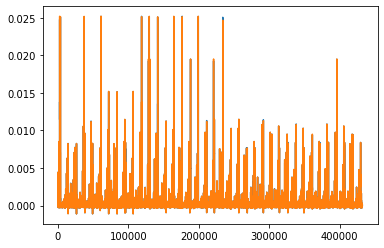

In [26]:
plt.plot(obs.tod[0])
plt.plot(obs.tod[1])

since we have few days of observation, it is pointless to generate a map

# Testing out_of_band_analysis against hwp_sys

Let's take now a top-hat band. Let's consider the actual 100 GHz one, in order to compare the result coming from out_of_band_analysis.py to the top-hat band that hwp_sys.py would consider by reading the frequencies in the parameter file `MFT_100_h_beta_z.txt`

Text(0, 0.5, 'transmission')

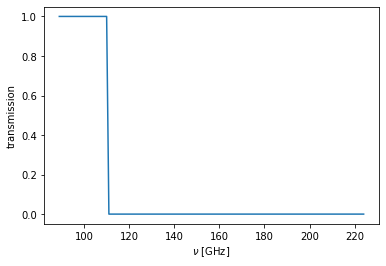

In [88]:
bandpass_parameters={'low edge': Nu[0],'high edge': Nu[-1]}
transmission=lbs.out_of_band_analysis.out_of_band_analysis.top_hat_bandpass(nu,
                                        bandpass_parameters['low edge'],
                                        bandpass_parameters['high edge'])
plt.plot(nu,transmission)
plt.xlabel(r'$\nu$ [GHz]')
plt.ylabel('transmission')

we generate a clean observation each time we want to compute a new tod, otherwise it would be summed over the old `obs.tod`

In [59]:
obs, = sim.create_observations(detectors=dets)

pointings = lbs.scanning.get_pointings(obs,
                                       spin2ecliptic_quats=sim.spin2ecliptic_quats,
                                       detector_quats=detquats,
                                       bore2spin_quat=instrumentinfo.bore2spin_quat,
                                      )

In [60]:
sim.parameter_file = par   #setting the parameter file
hwp_sys_band = lbs.HwpSysAndBandpass(sim)

Let's initialise Mbsparams in order to set a seed for the cmb map. The FG is always the same

In [61]:
Mbsparams = lbs.MbsParameters(
                make_cmb=True,
                make_fg=True,
                fg_models = ["pysm_synch_0", "pysm_freefree_1", "pysm_dust_0"],
                bandpass_int=True,
                maps_in_ecliptic=True,
                seed_cmb = 1234,
            )

In [62]:
hwp_sys_band.set_parameters(#maps=maps,    # ---> to use without band integration
                       integrate_in_band=True,
                       correct_in_solver=True,
                       built_map_on_the_fly=False,
                       nside=nside,
                       bandpass_parameters={'low edge': Nu[0],
                                            'high edge': Nu[-1]}, #100GHz band
                       include_beam_throughput=False,
                       Mbsparams = Mbsparams
                      )

[2022-01-26 17:05:28,009 INFO MPI#0000] using the passed instrument to generate maps
[2022-01-26 17:05:28,013 INFO MPI#0000] generating and saving cmb simulations
[2022-01-26 17:05:28,027 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-01-26 17:05:28,028 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-01-26 17:05:28,045 INFO MPI#0000] NSIDE = 64
[2022-01-26 17:05:28,046 INFO MPI#0000] ORDERING = RING in fits file
[2022-01-26 17:05:28,047 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-01-26 17:05:28,176 INFO MPI#0000] generating and saving fg simulations
[2022-01-26 17:05:28,179 INFO MPI#0000] NSIDE = 512
[2022-01-26 17:05:28,179 INFO MPI#0000] ORDERING = RING in fits file
[2022-01-26 17:05:28,180 INFO MPI#0000] INDXSCHM = IMPLICIT


***************** D
***************** D
***************** D


[2022-01-26 17:05:28,313 INFO MPI#0000] NSIDE = 512
[2022-01-26 17:05:28,313 INFO MPI#0000] ORDERING = RING in fits file
[2022-01-26 17:05:28,314 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-01-26 17:05:28,426 INFO MPI#0000] NSIDE = 512
[2022-01-26 17:05:28,427 INFO MPI#0000] ORDERING = RING in fits file
[2022-01-26 17:05:28,427 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-01-26 17:05:29,970 INFO MPI#0000] NSIDE = 512
[2022-01-26 17:05:29,970 INFO MPI#0000] ORDERING = RING in fits file
[2022-01-26 17:05:29,973 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-01-26 17:05:30,156 INFO MPI#0000] NSIDE = 512
[2022-01-26 17:05:30,157 INFO MPI#0000] ORDERING = RING in fits file
[2022-01-26 17:05:30,159 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-01-26 17:05:30,274 INFO MPI#0000] NSIDE = 512
[2022-01-26 17:05:30,275 INFO MPI#0000] ORDERING = RING in fits file
[2022-01-26 17:05:30,275 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-01-26 17:05:30,394 INFO MPI#0000] NSIDE = 512
[2022-01-26 17:05:30,394 INFO MPI#0000] ORD

In [63]:
hwp_sys_band.fill_tod(obs,pointings,hwp_radpsec)

In [64]:
obs.tod

array([[3.9212668e-05, 3.9152383e-05, 3.8570895e-05, ..., 3.9716084e-05,
        3.9661580e-05, 4.0437997e-05],
       [3.9393406e-05, 3.8512757e-05, 3.8602575e-05, ..., 3.9676990e-05,
        4.0629755e-05, 3.8746908e-05]], dtype=float32)

let's create a new simulation, initialise hwp_sys and compute the same kind of tod

In [65]:
sim1 = lbs.Simulation(base_path="./tutorial",
                     start_time=0,
                     duration_s=mission_time_is_sec,
                    )

In [66]:
mft_file = sim1.imo.query("/releases/v1.0/satellite/"+instrument+"/instrument_info")
sim1.generate_spin2ecl_quaternions(imo_url="/releases/v1.0/satellite/scanning_parameters/")

In [67]:
obs1, = sim1.create_observations(detectors=dets)

pointings1 = lbs.scanning.get_pointings(obs1,
                                       spin2ecliptic_quats=sim1.spin2ecliptic_quats,
                                       detector_quats=detquats,
                                       bore2spin_quat=instrumentinfo.bore2spin_quat,
                                      )

In [68]:
sim1.parameter_file = par
hwp_sys = lbs.HwpSys(sim1)

In [69]:
hwp_sys.set_parameters(#maps=maps,    # ---> to use without band integration
                       integrate_in_band=True,
                       correct_in_solver=True,
                       built_map_on_the_fly=False,
                       nside=nside,
                        Mbsparams = Mbsparams
                      )

[2022-01-26 17:05:36,887 INFO MPI#0000] using the passed instrument to generate maps
[2022-01-26 17:05:36,890 INFO MPI#0000] generating and saving cmb simulations
[2022-01-26 17:05:36,904 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-01-26 17:05:36,904 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-01-26 17:05:36,933 INFO MPI#0000] NSIDE = 64
[2022-01-26 17:05:36,934 INFO MPI#0000] ORDERING = RING in fits file
[2022-01-26 17:05:36,935 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-01-26 17:05:37,092 INFO MPI#0000] generating and saving fg simulations
[2022-01-26 17:05:37,095 INFO MPI#0000] NSIDE = 512
[2022-01-26 17:05:37,096 INFO MPI#0000] ORDERING = RING in fits file
[2022-01-26 17:05:37,097 INFO MPI#0000] INDXSCHM = IMPLICIT


***************** D
***************** D
***************** D


[2022-01-26 17:05:37,232 INFO MPI#0000] NSIDE = 512
[2022-01-26 17:05:37,232 INFO MPI#0000] ORDERING = RING in fits file
[2022-01-26 17:05:37,233 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-01-26 17:05:37,353 INFO MPI#0000] NSIDE = 512
[2022-01-26 17:05:37,353 INFO MPI#0000] ORDERING = RING in fits file
[2022-01-26 17:05:37,354 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-01-26 17:05:38,645 INFO MPI#0000] NSIDE = 512
[2022-01-26 17:05:38,646 INFO MPI#0000] ORDERING = RING in fits file
[2022-01-26 17:05:38,647 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-01-26 17:05:38,820 INFO MPI#0000] NSIDE = 512
[2022-01-26 17:05:38,821 INFO MPI#0000] ORDERING = RING in fits file
[2022-01-26 17:05:38,822 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-01-26 17:05:38,928 INFO MPI#0000] NSIDE = 512
[2022-01-26 17:05:38,929 INFO MPI#0000] ORDERING = RING in fits file
[2022-01-26 17:05:38,929 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-01-26 17:05:39,037 INFO MPI#0000] NSIDE = 512
[2022-01-26 17:05:39,037 INFO MPI#0000] ORD

we see that the maps generated by the two classes are exactly the same

In [70]:
hwp_sys.maps == hwp_sys_band.maps

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       ...,

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        

In [71]:
hwp_sys.fill_tod(obs1,pointings1,hwp_radpsec)

In [72]:
obs1.tod

array([[3.9212668e-05, 3.9152383e-05, 3.8570895e-05, ..., 3.9716084e-05,
        3.9661580e-05, 4.0437997e-05],
       [3.9393406e-05, 3.8512757e-05, 3.8602575e-05, ..., 3.9676990e-05,
        4.0629755e-05, 3.8746908e-05]], dtype=float32)

In [73]:
obs.tod == obs1.tod

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

the two tod are exactly the same when we set `include_beam_throughput=False` in `hwp_sys_band.set_parameters`